<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Analytical-results-for-test-1(Section-6-)" data-toc-modified-id="Analytical-results-for-test-1(Section-6-)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analytical results for test 1(Section 6 )</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#sobol-indices" data-toc-modified-id="sobol-indices-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>sobol indices</a></span></li><li><span><a href="#quantiles" data-toc-modified-id="quantiles-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>quantiles</a></span></li><li><span><a href="#Quantile-based-measures" data-toc-modified-id="Quantile-based-measures-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Quantile-based measures</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-2.0.6"><span class="toc-item-num">2.0.6&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></li><li><span><a href="#Monte-Carlo-estimators(section-4)" data-toc-modified-id="Monte-Carlo-estimators(section-4)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Monte Carlo estimators(section 4)</a></span><ul class="toc-item"><li><span><a href="#The-brute-force-estimator(section-4.1-)" data-toc-modified-id="The-brute-force-estimator(section-4.1-)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The brute force estimator(section 4.1 )</a></span></li><li><span><a href="#DLR-MC-estimator(section-4.2)" data-toc-modified-id="DLR-MC-estimator(section-4.2)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DLR MC estimator(section 4.2)</a></span></li><li><span><a href="#Main-function" data-toc-modified-id="Main-function-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Main function</a></span></li><li><span><a href="#convergence-plot" data-toc-modified-id="convergence-plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>convergence plot</a></span></li></ul></li><li><span><a href="#Numerical-tests(section-7)" data-toc-modified-id="Numerical-tests(section-7)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Numerical tests(section 7)</a></span><ul class="toc-item"><li><span><a href="#Test-1:-independent-normal-(p43)" data-toc-modified-id="Test-1:-independent-normal-(p43)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test 1: independent normal (p43)</a></span><ul class="toc-item"><li><span><a href="#The-brute-force-estimator" data-toc-modified-id="The-brute-force-estimator-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>The brute force estimator</a></span></li><li><span><a href="#Double-loop-reordering-(DLR)-estimator" data-toc-modified-id="Double-loop-reordering-(DLR)-estimator-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Double loop reordering (DLR) estimator</a></span></li></ul></li><li><span><a href="#Test-2:--independent-exponential-(p45)" data-toc-modified-id="Test-2:--independent-exponential-(p45)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Test 2:  independent exponential (p45)</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>pdf of output</a></span></li><li><span><a href="#The-Brute-Force-estimator" data-toc-modified-id="The-Brute-Force-estimator-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>The Brute Force estimator</a></span></li><li><span><a href="#The-DLR-estimator" data-toc-modified-id="The-DLR-estimator-4.2.5"><span class="toc-item-num">4.2.5&nbsp;&nbsp;</span>The DLR estimator</a></span></li><li><span><a href="#Plot-Fig.-3-(p39)" data-toc-modified-id="Plot-Fig.-3-(p39)-4.2.6"><span class="toc-item-num">4.2.6&nbsp;&nbsp;</span>Plot Fig. 3 (p39)</a></span></li></ul></li><li><span><a href="#Test-3:--independent-uniform-(p45)" data-toc-modified-id="Test-3:--independent-uniform-(p45)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test 3:  independent uniform (p45)</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>pdf of output</a></span></li><li><span><a href="#The-Brute-Force-estimator" data-toc-modified-id="The-Brute-Force-estimator-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>The Brute Force estimator</a></span></li><li><span><a href="#DLR-estimator" data-toc-modified-id="DLR-estimator-4.3.5"><span class="toc-item-num">4.3.5&nbsp;&nbsp;</span>DLR estimator</a></span><ul class="toc-item"><li><span><a href="#Fig.-4-(p40)" data-toc-modified-id="Fig.-4-(p40)-4.3.5.1"><span class="toc-item-num">4.3.5.1&nbsp;&nbsp;</span>Fig. 4 (p40)</a></span></li></ul></li></ul></li><li><span><a href="#Test-4:-correlated-multivariate-normal" data-toc-modified-id="Test-4:-correlated-multivariate-normal-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Test 4: correlated multivariate normal</a></span><ul class="toc-item"><li><span><a href="#Objective-function" data-toc-modified-id="Objective-function-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Objective function</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#pdf-of-output" data-toc-modified-id="pdf-of-output-4.4.3"><span class="toc-item-num">4.4.3&nbsp;&nbsp;</span>pdf of output</a></span></li><li><span><a href="#The-Brute-Force-estimator" data-toc-modified-id="The-Brute-Force-estimator-4.4.4"><span class="toc-item-num">4.4.4&nbsp;&nbsp;</span>The Brute Force estimator</a></span></li><li><span><a href="#The-DLR-estimator" data-toc-modified-id="The-DLR-estimator-4.4.5"><span class="toc-item-num">4.4.5&nbsp;&nbsp;</span>The DLR estimator</a></span><ul class="toc-item"><li><span><a href="#Fig.-5.--(p42)" data-toc-modified-id="Fig.-5.--(p42)-4.4.5.1"><span class="toc-item-num">4.4.5.1&nbsp;&nbsp;</span>Fig. 5.  (p42)</a></span></li></ul></li></ul></li></ul></li></ul></div>

**To do:**


- <a href="#Fig.-5.--(p42)" data-toc-modified-id="Fig.-5.--(p42)-3.2.4.6"><span class="toc-item-num">3.2.4.6&nbsp;&nbsp;</span>Fig. 5.  (p42)</a>   
   For test 4 (correlated inputs), the estimated results are not accurate.

# Introduction 


New global sensitivity measures based on quantiles of the output has been introduced by [Kucherenko et al.(2019)](https://www.sciencedirect.com/science/article/abs/pii/S0951832016304574) in which $\alpha$th quantiles are the functions of interest. This notebook reproduces the numerical test results of the paper. 

In [1]:
import numpy as np
import chaospy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,uniform,expon
# from temfpy.uncertainty_quantification import simple_linear_function

from numpy.testing import assert_almost_equal

# Analytical results for test 1(Section 6 )

For **linear model with normally distributed variables**, analytical values of sensitivity indices can be found and used as benchmarks for verification of numerical estimates. 

### Parameters

In [2]:
# mean and covariance
mean_1 = np.array([1, 3, 5, 7])
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

sd_1 = np.sqrt(np.diag(cov_1))

# dimension 
n_params_1 = 4

# range of alpha
dalp = (0.98 - 0.02) / 30   # 0.032
alp = np.arange(0.02, 0.98 + dalp, dalp) 
len_alp = len(alp)

### Objective function
$$Y=x_1+x_2+x_3+x_4$$

In [3]:
# objective function (Eq.32)
# copy from temfpy because conda install of tempy dosen'work
def simple_linear_function(x):
    r"""Uncomplicated linear function.

    This function computes the sum of all elements of a given array.

    Parameters
    ----------
    x : array_like
        Array of summands

    Examples
    --------
    >>> from temfpy.uncertainty_quantification import simple_linear_function
    >>> import numpy as np
    >>>
    >>> x = [1, 2, 3]
    >>> y = simple_linear_function(x)
    >>> np.testing.assert_almost_equal(y, 6)
    """
    return sum(x)

def simple_linear_function_transposed(x):
    """Simple linear function model but with variables stored in columns."""
    return simple_linear_function(x.T)

### sobol indices

$$
S_i=S_i^{tot}=\frac{a_i^2 \sigma_i^2}{\sum_{j=1}^d a_j^2 \sigma_j^2}
$$

In [4]:
# sobol indices
sobol_1 = [cov_1[i, i] / np.trace(cov_1) for i in range(n_params_1)]

print(sobol_1)

# for plot convinence
sobol_1 = np.tile(sobol_1, (len_alp, 1))

[0.07407407407407407, 0.16666666666666666, 0.2962962962962963, 0.46296296296296297]


### quantiles

In [5]:
quantile_y_true = [sum(mean_1) + norm.ppf(a) * (np.sqrt(np.trace(cov_1))) for a in alp]
    
quantile_y_true

[8.454044663732835,
 10.02656389184387,
 10.934484378158178,
 11.608471084792363,
 12.160242219982202,
 12.636733909640807,
 13.062445960676326,
 13.451942742386048,
 13.814690738352308,
 14.157270670719067,
 14.484513692735543,
 14.800138536864447,
 15.107135388856603,
 15.40801250510684,
 15.704965159312176,
 16.0,
 16.295034840687826,
 16.59198749489316,
 16.8928646111434,
 17.199861463135555,
 17.515486307264457,
 17.842729329280935,
 18.185309261647692,
 18.54805725761395,
 18.937554039323672,
 19.363266090359197,
 19.8397577800178,
 20.391528915207637,
 21.065515621841822,
 21.973436108156136,
 23.545955336267163]

In [6]:
quantile_y_true = []
for a in alp:
    quantile_y_a = sum(mean_1) + norm.ppf(a) * (np.sqrt(np.trace(cov_1)))
    quantile_y_true.append(quantile_y_a)
    
quantile_y_true

[8.454044663732835,
 10.02656389184387,
 10.934484378158178,
 11.608471084792363,
 12.160242219982202,
 12.636733909640807,
 13.062445960676326,
 13.451942742386048,
 13.814690738352308,
 14.157270670719067,
 14.484513692735543,
 14.800138536864447,
 15.107135388856603,
 15.40801250510684,
 15.704965159312176,
 16.0,
 16.295034840687826,
 16.59198749489316,
 16.8928646111434,
 17.199861463135555,
 17.515486307264457,
 17.842729329280935,
 18.185309261647692,
 18.54805725761395,
 18.937554039323672,
 19.363266090359197,
 19.8397577800178,
 20.391528915207637,
 21.065515621841822,
 21.973436108156136,
 23.545955336267163]

### Quantile-based measures
$q_i^{(2)}(\alpha)$ of linear model with normally distributed variables is obtained from following formula:

$$
q_i^{(2)}(\alpha)=a_i^2 \sigma_i^2+[\Phi^{-1}(\alpha)]^2 \left(\sqrt{\sum_{i=1}^d a_i^2 \sigma_i^2}-\sqrt{\sum_{j=1,j \ne i}^d a_j^2 \sigma_j^2} \right)^2
\tag{30}
$$

In [7]:
# q_2: PDF of the output Y(Eq.30)
q_2_true = [
    (
        cov_1[i, i]
        + norm.ppf(a) ** 2
        * (
            np.sqrt(np.trace(cov_1))
            - np.sqrt(sum(cov_1[j, j] for j in range(n_params_1) if j != i))
        )
        ** 2
    )
    for a in alp
    for i in range(n_params_1)
]
    
q_2_true = np.vstack(q_2_true).reshape((len(alp), n_params_1))
q_2_true

array([[ 1.08114318,  2.68226953,  5.4783546 , 10.31452679],
       [ 1.05084778,  2.52087855,  4.92640012,  8.79700604],
       [ 1.03656545,  2.44479306,  4.66618903,  8.08159246],
       [ 1.02748243,  2.39640559,  4.50070468,  7.62661666],
       [ 1.02101025,  2.36192673,  4.38278756,  7.30242023],
       [ 1.0161193 ,  2.33587142,  4.29367881,  7.05742834],
       [ 1.01229689,  2.31550854,  4.2240381 ,  6.86596106],
       [ 1.00925213,  2.29928838,  4.16856543,  6.71344681],
       [ 1.00680533,  2.28625367,  4.12398695,  6.59088457],
       [ 1.0048389 ,  2.275778  ,  4.08816034,  6.49238438],
       [ 1.00327286,  2.26743533,  4.05962854,  6.41394024],
       [ 1.00205157,  2.2609292 ,  4.03737768,  6.35276465],
       [ 1.00113604,  2.25605198,  4.02069767,  6.3069053 ],
       [ 1.0004994 ,  2.25266043,  4.00909861,  6.27501535],
       [ 1.00012404,  2.2506608 ,  4.00225994,  6.25621338],
       [ 1.        ,  2.25      ,  4.        ,  6.25      ],
       [ 1.00012404,  2.

In [8]:
# warning: works only in this case
q_1_true = np.sqrt(q_2_true)

In [9]:
norm_q_2_true = [q[i] / sum(q) for q in q_2_true for i in range(n_params_1)]
norm_q_2_true = np.hstack(norm_q_2_true).reshape((len(alp), n_params_1))

In [10]:
df_norm_q_2_true = pd.DataFrame(norm_q_2_true, columns=["x_1", "x_2","x_3", "x_4" ])
df_norm_q_2_true["alpha"] = alp
df_norm_q_2_true.set_index("alpha",inplace=True)

In [11]:
# Q_1: normalized quantile based sensitivity measure 
norm_q_1_true = [q[i] / sum(q) for q in q_1_true for i in range(n_params_1)]

norm_q_1_true = np.hstack(norm_q_1_true).reshape((len(alp), n_params_1))

norm_q_1_true

array([[0.12634401, 0.19900512, 0.28440557, 0.39024531],
       [0.13145182, 0.2035976 , 0.28461746, 0.38033312],
       [0.13423404, 0.20615096, 0.2848036 , 0.37481139],
       [0.13615517, 0.20793477, 0.28496217, 0.37094789],
       [0.13760513, 0.20929208, 0.28509841, 0.36800438],
       [0.13874958, 0.21036999, 0.28521614, 0.3656643 ],
       [0.13967517, 0.21124598, 0.28531801, 0.36376083],
       [0.14043309, 0.21196607, 0.28540589, 0.36219495],
       [0.14105599, 0.21255973, 0.28548115, 0.36090313],
       [0.14156585, 0.21304691, 0.28554479, 0.35984245],
       [0.14197796, 0.21344149, 0.28559759, 0.35898297],
       [0.14230316, 0.21375337, 0.28564011, 0.35830336],
       [0.14254917, 0.21398962, 0.28567278, 0.35778844],
       [0.14272139, 0.21415514, 0.2856959 , 0.35742756],
       [0.14282337, 0.21425322, 0.2857097 , 0.35721371],
       [0.14285714, 0.21428571, 0.28571429, 0.35714286],
       [0.14282337, 0.21425322, 0.2857097 , 0.35721371],
       [0.14272139, 0.21415514,

### Plot

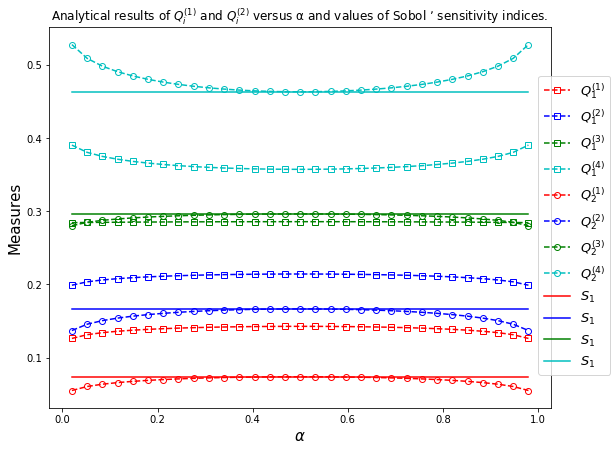

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
            
ax.set_title(r'Analytical results of $Q_i^{(1)}$ and $Q_i^{(2)}$ versus α and values of Sobol ’ sensitivity indices.')
ax.set_xlabel(r"$\alpha$", fontsize=15)
ax.set_ylabel("Measures", fontsize=15)

colors = ['r','b','g','c']   

for i in range(n_params_1):
    ax.plot(alp, sobol_1[:, i], colors[i]+'-', label=r'$S_1$')
    ax.plot(alp, norm_q_1_true[:,i], colors[i]+'s--', label=r'$Q_1^{(%s)}$'%(i+1), markerfacecolor='none')
    ax.plot(alp, norm_q_2_true[:,i], colors[i]+'o--', label=r'$Q_2^{(%s)}$'%(i+1), markerfacecolor='none')

# legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels,fontsize=13,loc='center right')

plt.show()


# Monte Carlo estimators(section 4)


## The brute force estimator(section 4.1 )


**Step 1: Sampling**  (inverse transform sampling) 

1. Generate two independent points: $x^j=(x_1^j, \dots, x_d^j)$ and $x'^{(j)}=(x_1'^{(j)}, \dots, x_d'^{(j)}), j=1, \dots, N$from the joint PDF $\rho(x_1, \dots, x_d)$
    1. Generate two n-dimensional **uniform distributed** samples with N points
    1. Transform both uniform draws distributed according to a joint PDF $\rho(x_1, \dots, x_d)$

1. Construct conditional sample: 
    1. Construct a mixed $\{(x_{~i}^j,x_i'^{(j)})\}$ set distributed according to a conditional PDF $\rho(x_1, \dots, x_d|X_i=X_i'^{(j)})$

**Step 2: Build a CDF  of output** 

1. CDF **$F_Y(y)$** of the output $Y$
$$
F_Y^{(N)}(y)=\frac{1}{N} \sum_{l=1}^N I(Y(x_1^l, \dots , x_d^l)<y)
\tag{21a}
$$
1. CDF **$F_{Y \mid X_i}(y)$** of the output conditional on the input variable $x_i$ being fixed at $x_i=X_i$
$$
F_{Y \mid X_i}^{N}(y)=\frac{1}{N} \sum_{l=1}^{N} I(Y(x_1^l, \dots , x_i^l = X_i^l, \dots , x_d^l)<y)
\tag{21b}
$$

**Step 3: Get quantiles of output**

1. Unconditional quantile 
    $$
    q_Y^{(N)}(\alpha)=[F_Y^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_Y^{(N)}(Y \le y) \ge \alpha \right\}
    \tag{22}
    $$
1. Conditional quantile 
    $$
    q_{Y \mid X_i}^{(N)}(\alpha)=[F_{Y \mid X_i}^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_{Y \mid X_i}^{(N)}(Y \le y \mid x_i=X_i) \ge \alpha \right\}
    \tag{23}
    $$

**Step 4: MC/QMC estimates of quantiles**

1. Quantile based measures
    $$
\tilde{q_i}^{(1)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \mid q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \mid
    \tag{27}
    $$

    $$
\tilde{q_i}^{(2)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \left( q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \right)^2
    \tag{28}
    $$
1. Nomalized quantile based measures
$$
Q_i^{(1)}(\alpha)=\frac{\bar{q}_i^{(1)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(1)}(\alpha)}
\tag{13}
$$   

$$
Q_i^{(2)}(\alpha)=\frac{\bar{q}_i^{(2)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(2)}(\alpha)}
\tag{14}
$$



## DLR MC estimator(section 4.2)


**Step 1: Sampling**  (inverse transform sampling) 

1. Generate $N$ points $x^{(j)},j=1,2, \dots, N$ from the joint PDF $\rho(x_1, \dots, x_d)$
    1. Generate N points of n-dimensional **uniform distributed** sample
    1. Transform the uniform draw into a joint PDF $\rho(x_1, \dots, x_d)$

1. Construct conditional sample: 
    1. Sort base sample set $x^{(j)},j=1,2, \dots, N$ in ascending order with respect to the values of $x_i$ and subdivided in **M equally populated partitions (bins)** with $N_m=N/M$ points in each bin $(M < N)$
    1. Within each bin a mixed $\{(x_{\sim i}^j,x_{i}^{'(j)})\}$ set distributed according to a conditional PDF $\rho(x_1, \dots, x_d|x_i=X_i^{'(j)})$  where $(x_{\sim i}^j,x_i^{'(j)})=(x_1^j, \dots, x_i^{'(j)}, \dots, x_d^j)$ 

**Step 2: Build a CDF  of output** 

1. CDF **$F_Y(y)$** of the out put $Y$
$$
F_Y^{(N)}(y)=\frac{1}{N} \sum_{l=1}^N I(Y(x_1^l, \dots , x_d^l)<y)
\tag{21a}
$$
1. Within each bin the CDF **$F_{Y|x_i}(y)$** of the output conditional on the input variable $x_i$ being fixed at $x_i=X_i^l,l=1,\dots, N_m$ is estimated as
$$
F_{Y \mid X_i}^{(N_m)}(y)=\frac{1}{N_m} \sum_{l=1}^{N_m} I(Y(x_1^l, \dots , x_i^l = X_i^l, \dots , x_d^l)<y)
\tag{26}
$$

**Step 3: Get quantiles of output**

1. Unconditional quantile 
    $$
    q_Y^{(N)}(\alpha)=[F_Y^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_Y^{(N)}(Y \le y) \ge \alpha \right\}
    \tag{22}
    $$
1. Conditional quantile 
    $$
    q_{Y \mid X_i}^{(N)}(\alpha)=[F_{Y \mid X_i}^{(N)}]^{-1}(\alpha)=\inf 	\left\{ y \mid F_{Y \mid X_i}^{(N)}(Y \le y \mid x_i=X_i) \ge \alpha \right\}
    \tag{23}
    $$

**Step 4: MC/QMC estimates of quantiles**

1. Quantile based measures
    $$
\tilde{q_i}^{(1)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \mid q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \mid
    \tag{27}
    $$

    $$
\tilde{q_i}^{(2)}(\alpha)=\frac{1}{M} \sum_{j=1}^M \left( q_Y^{(N_m)}(\alpha)-q_{Y \mid X_i^{j}}^{(N_m)}(\alpha) \right)^2
    \tag{28}
    $$
1. Nomalized quantile based measures
$$
Q_i^{(1)}(\alpha)=\frac{\bar{q}_i^{(1)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(1)}(\alpha)}
\tag{13}
$$   

$$
Q_i^{(2)}(\alpha)=\frac{\bar{q}_i^{(2)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(2)}(\alpha)}
\tag{14}
$$



## Main function

In [14]:
"""Capabilities for quantile-based sensitivity analysis.

This module contains functions to calculate the global sensitivity measures based on
quantiles of the output introduced by Kucherenko et al.(2019). Both the brute force
and double loop reordering MC estimators are included.

"""
import chaospy as cp
import numpy as np
import pandas as pd
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform


def mc_quantile_measures(
    estimator,
    func,
    n_params,
    loc,
    scale,
    dist_type,
    n_draws,
    sampling_scheme="sobol",
    seed=0,
    skip=0,
):
    r"""Compute the MC/QMC estimators of quantile-based global sensitivity measures.

    The algorithm is described in Section 4 of Kucherenko et al.(2019).

    Parameters
    ----------
    estimator : string
        Specify the Monte Carlo estimator. One of ["brute force", "DLR"], where "DLR" denotes
        to the double loop reordering approach.

    func : callable
        Objective function to estimate the quantile-based measures. Must be broadcastable.

    n_params : int
        Number of parameters of objective function.

    loc : float or np.ndarray
        The location(`loc`) keyword passed to `scipy.stats.norm`_ function to shift the
        location of "standardized" distribution. Specifically, for normal distribution
        it specifies the mean array with the length of `n_params`.

        .. _scipy.stats.norm: https://docs.scipy.org/doc/scipy/reference/generated/
            _scipy.stats.norm.html

    scale : float or np.ndarray
        The `scale` keyword passed to `scipy.stats.norm`_ function to adjust the scale of
        "standardized" distribution. Specifically, for normal distribution it specifies
        the covariance matrix of shape (n_params, n_params).

    dist_type : str
        The distribution type of inputs. Options are "Normal", "Exponential" and "Uniform".

    n_draws : int
        Number of Monte Carlo draws. For double loop reordering estimator,
        S. Kucherenko and S. Song(2017). suggests that `n_draws` should always be equal
        to :math:`2^p` to preserve the uniformity properties , where :math:`p`
        is an integer.

    sampling_scheme : str, optional
        One of ["random", "sobol"], default "sobol".

    seed : int, optional
        Random number generator seed.

    skip : int, optional
        Number of values to skip of Sobol sequence. Default is `0`.

    Returns
    -------
    df_measures : pd.DataFrame
        DataFrame containing quantile-based sensitivity measures.
    """
    # range of alpha
    dalp = (0.98 - 0.02) / 30
    alpha_grid = np.arange(0.02, 0.98 + dalp, dalp)  # len(alpha_grid) = 31

    # get the two independent groups of sample points
    x, x_prime = _unconditional_samples(
        n_draws,
        n_params,
        dist_type,
        loc,
        scale,
        sampling_scheme="sobol",
        seed=0,
        skip=0,
    )

    # get the conditional sample sets
    if estimator == "brute force":
        x_mix = _bf_conditional_samples(x, x_prime)
    elif estimator == "DLR":
        x_mix = _dlr_conditional_samples(x)
    else:
        raise NotImplementedError

    # quantiles of output with unconditional input
    quantile_y_x = _unconditional_quantile_y(x, alpha_grid, func)

    # quantiles of output with conditional input
    quantile_y_x_mix = _conditional_quantile_y(x_mix, func, alpha_grid)

    # Get quantile based measures
    q_1, q_2 = _quantile_measures(quantile_y_x, quantile_y_x_mix)

    # Get normalized quantile based measures
    norm_q_1, norm_q_2 = _normalized_quantile_measures(q_1, q_2)

    # store results
    dict_measures = {
        "q_1": pd.DataFrame(q_1),
        "q_2": pd.DataFrame(q_2),
        "Q_1": pd.DataFrame(norm_q_1),
        "Q_2": pd.DataFrame(norm_q_2),
    }
    df_measures = pd.concat(dict_measures.values(), axis=0)
    df_measures.index = pd.MultiIndex.from_product(
        [dict_measures.keys(), alpha_grid],
        names=["Measures", "alpha"],
    )
    df_measures.columns = [f"x_{i + 1}" for i in range(n_params)]

    return df_measures


def _unconditional_samples(
    n_draws,
    n_params,
    dist_type,
    loc,
    scale,
    sampling_scheme="sobol",
    seed=0,
    skip=0,
):
    """Generate two independent groups of sample points.

    Parameters
    ----------
    n_draws : int
        Number of Monte Carlo draws.
    n_params : int
        Number of parameters of objective function.
    dist_type : str
        The distribution type of input. Options are "Normal", "Exponential" and "Uniform".
    loc : float or np.ndarray
        The location(`loc`) keyword passed to `scipy.stats.norm`_ function to shift the
        location of "standardized" distribution.
    scale : float or np.ndarray
        The `scale` keyword passed to `scipy.stats.norm`_ function to adjust the scale of
        "standardized" distribution.
    sampling_scheme : str, optional
        One of ["sobol", "random"]
    seed : int, optional
        Random number generator seed. Default is 0.
    skip : int, optional
        Number of values to skip of Sobol sequence. Default is `0`.

    Returns
    -------
    x, x_prime : np.ndarray
        Two arrays of shape (n_draws, n_params) with i.i.d draws from a joint distribution.
    """
    # Generate uniform distributed samples
    np.random.seed(seed)
    if sampling_scheme == "sobol":
        u = cp.generate_samples(
            order=n_draws + skip,
            domain=n_params,
            rule="S",
        ).T
    elif sampling_scheme == "random":
        u = np.random.uniform(size=(n_draws, n_params))
    else:
        raise ValueError("Argument 'sampling_scheme' is not in {'sobol', 'random'}.")

    skip = skip if sampling_scheme == "sobol" else 0

    u = cp.generate_samples(order=n_draws, domain=2 * n_params, rule="S").T
    u_1 = u[skip:, :n_params]
    u_2 = u[skip:, n_params:]

    # Transform uniform draws into a joint PDF
    if dist_type == "Normal":
        z = norm.ppf(u_1)
        z_prime = norm.ppf(u_2)
        cholesky = np.linalg.cholesky(scale)
        x = loc + cholesky.dot(z.T).T
        x_prime = loc + cholesky.dot(z_prime.T).T
    elif dist_type == "Exponential":
        x = expon.ppf(u_1, loc, scale)
        x_prime = expon.ppf(u_2, loc, scale)
    elif dist_type == "Uniform":
        x = uniform.ppf(u_1, loc, scale)
        x_prime = uniform.ppf(u_2, loc, scale)
    else:
        raise NotImplementedError

    return x, x_prime


def _bf_conditional_samples(x, x_prime):
    """Generate mixed sample sets distributed accroding to a conditional PDF.

    Parameters
    ----------
    x : np.ndarray
        Array with shape (n_draws, n_params).
    x_prime : np.ndarray
        Array with shape (n_draws, n_params).

    Returns
    -------
    x_mix :  np.ndarray
        Mixed sample sets. Shape has the form (n_draws, n_params, n_draws, n_params).
    """
    n_draws, n_params = x.shape
    x_mix = np.zeros((n_draws, n_params, n_draws, n_params))

    for i in range(n_params):
        for j in range(n_draws):
            x_mix[j, i] = x
            x_mix[j, i, :, i] = x_prime[j, i]

    return x_mix


def _dlr_conditional_samples(x):
    """Generate conditional sample sets.

    Parameters
    ----------
    x : np.ndarray
        Draws from a joint distribution. Shape has the form (n_draws, n_params).

    Returns
    -------
    x_mix :  np.ndarray
        Mixed sample sets. Shape has the form (m, n_params, n_draws, n_params),  where m
        is the number of conditional bins.
    """
    n_draws, n_params = x.shape

    # The dependence of m versus n_draws accroding to S. Kucherenko and S. Song(2017).
    if n_draws == 2 ** 6:
        m = 2 ** 3
    elif n_draws <= 2 ** 9:
        m = 2 ** 4
    elif n_draws == 2 ** 10:
        m = 2 ** 5
    elif n_draws <= 2 ** 13:
        m = 2 ** 6
    elif n_draws <= 2 ** 15:
        m = 2 ** 7
    else:
        raise NotImplementedError

    conditional_bin = x[:m]
    x_mix = np.zeros((m, n_params, n_draws, n_params))

    # subdivide unconditional samples into M eaually bins, within each bin x_i being fixed.
    for i in range(n_params):
        for j in range(m):
            x_mix[j, i] = x
            x_mix[j, i, :, i] = conditional_bin[j, i]

    return x_mix


def _unconditional_quantile_y(x, alpha_grid, func):
    """Return quantiles of outputs with unconditional input.

    Parameters
    ----------
    x : np.ndarray
        Draws from a joint distribution. Shape has the form (n_draws, n_params).
    alpha_grid : np.ndarray
        A sequence of evenly spaced values on the interval (0, 1).
    func : callable
        Objective function to calculate the quantile-based measures. Must be broadcastable.

    Returns
    -------
    quantile_y_x :  np.ndarray
        Quantiles of outputs corresponding to alpha with unconditional inputs.
        Shape has the form (len(alpha_grid),).

    """
    n_draws = x.shape[0]

    # Equation 21a
    y_x = func(x)
    y_x_asc = np.sort(y_x)
    q_index = (np.floor(alpha_grid * n_draws)).astype(int)
    quantile_y_x = y_x_asc[q_index]

    return quantile_y_x


def _conditional_quantile_y(x_mix, func, alpha_grid):
    """Return quantiles of outputs with conditional input.

    Parameters
    ----------
    x_mix : np.ndarray
        Mixed draws. Shape has the form (m, n_params, n_draws, n_params).
    func : callable
        Objective function to calculate the quantile-based measures. Must be broadcastable.
    alpha_grid : np.ndarray
        A sequence of evenly spaced values on the interval (0, 1).

    Returns
    -------
    quantile_y_x_mix  :  np.ndarray
        Quantiles of output corresponding to alpha with conditional inputs. Shape has the form
        (m, n_params, len(alpha_grid), 1), where m is the number of conditional bins.
    """
    m, n_params, n_draws = x_mix.shape[:3]

    y_x_mix = np.zeros((m, n_params, n_draws, 1))
    y_x_mix_asc = np.zeros((m, n_params, n_draws, 1))
    quantile_y_x_mix = np.zeros((m, n_params, len(alpha_grid), 1))

    # Equation 21b/26. Get quantiles within each bin.
    for i in range(n_params):
        for j in range(m):
            # values of conditional outputs
            y_x_mix[j, i] = np.vstack(func(x_mix[j, i]))
            y_x_mix_asc[j, i] = np.sort(y_x_mix[j, i], axis=0)
            for pp, a in enumerate(alpha_grid):
                quantile_y_x_mix[j, i, pp] = y_x_mix_asc[j, i][
                    (np.floor(a * n_draws)).astype(int)
                ]  # quantiles corresponding to alpha
    return quantile_y_x_mix


def _quantile_measures(quantile_y_x, quantile_y_x_mix):
    """Estimate the values of quantile based measures."""
    m, n_params, len_alp = quantile_y_x_mix.shape[:3]

    # initialization
    q_1 = np.zeros((len_alp, n_params))
    q_2 = np.zeros((len_alp, n_params))
    delt = np.zeros((m, n_params, len_alp, 1))

    # Equation 24&25&27&28
    for j in range(m):
        for i in range(n_params):
            for pp in range(len_alp):
                delt[j, i, pp] = quantile_y_x_mix[j, i, pp] - quantile_y_x[pp]
                q_1[pp, i] = np.mean(np.absolute(delt[:, i, pp]))
                q_2[pp, i] = np.mean(delt[:, i, pp] ** 2)

    return q_1, q_2


def _normalized_quantile_measures(q_1, q_2):
    """Estimate the values of normalized quantile based measures."""
    len_alp, n_params = q_1.shape

    # initialization
    sum_q_1 = np.zeros(len_alp)
    sum_q_2 = np.zeros(len_alp)
    norm_q_1 = np.zeros((len_alp, n_params))
    norm_q_2 = np.zeros((len_alp, n_params))

    # Equation 13 & 14
    for pp in range(len_alp):
        sum_q_1[pp] = np.sum(q_1[pp, :])
        sum_q_2[pp] = np.sum(q_2[pp, :])
        for i in range(n_params):
            norm_q_1[pp, i] = q_1[pp, i] / sum_q_1[pp]
            norm_q_2[pp, i] = q_2[pp, i] / sum_q_2[pp]

    return norm_q_1, norm_q_2


## convergence plot

In [ ]:
# bf_N_list = [2**6,2**7, 2**8, 2**9,2**10,2**11,2**12]

# bf_norm_q_2_3= [bf_mcs_quantile(simple_linear_function_transposed, n_params_1, mean_1, cov_1,"Normal",n )[3][2][15] for n in bf_N_list]

In [46]:
# dlr_N_list = [2**6,2**7, 2**8, 2**9,2**10,2**11,2**12,2**13, 2**14, 2**15]

# dlr_norm_q_2_3= [dlr_mcs_quantile(simple_linear_function_transposed, n_params_1, mean_1, cov_1, "Normal", n, skip=0,)[3][:,2][15] for n in dlr_N_list]

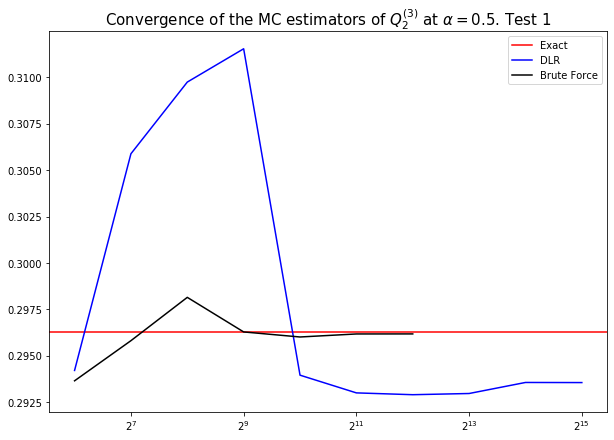

In [47]:
# fig, ax = plt.subplots(figsize=(10,7))

# ax.axhline(norm_q_2_true[:, 2][15], c='r', label='Exact')
# ax.plot(dlr_N_list, dlr_norm_q_2_3, c='b', label='DLR')
# ax.plot(bf_N_list, bf_norm_q_2_3, c='black',label='Brute Force')

# ax.set_title(r"Convergence of the MC estimators of $Q_2^{(3)}$ at $\alpha = 0.5$. Test 1", fontsize=15)
# ax.set_xscale('log', basex=2)
# ax.legend()
# plt.show()

# Numerical tests(section 7)

## Test 1: independent normal (p43)
   $Y=a_1x_1+a_2x_2+a_3x_3+a_4x_4$, where $x_i \sim N(\mu_i,\sigma^2)$ 

### The brute force estimator

In [15]:
# N=3000
bf_measures_1 = mc_quantile_measures("brute force", simple_linear_function_transposed, n_params_1, mean_1, cov_1, "Normal",3000,)

In [19]:
def plot_quantile_measures(df_measures):
    
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5)

    fig, ax = plt.subplots(figsize=(8,6))
    
    n_params = len(df_measures.columns)

    style_1 = [f'C{i}s--' for i in range(n_params)]
    style_2 = [f'C{i}o--' for i in range(n_params)]

    for q, s in zip(["Q_1", "Q_2"], [style_1, style_2]):
        df_measures.loc[q].plot(ax=ax, style=s, markerfacecolor='none')

    ax.set_title(r"Values of $Q_i^{(1)}$ and $Q_i^{(2)}$ versus $\alpha$")
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_ylabel("Measures")
    ax.set_xlabel(r"$\alpha$")

    labels = [f'$Q_{i+1}^{{({p})}}$' for p in [1,2] for i in range(n_params)]    
    ax.legend(labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
    
    return ax

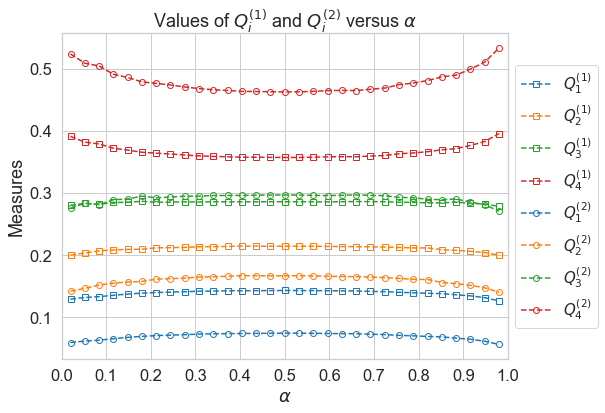

In [20]:
plot_quantile_measures(bf_measures_1)

### Double loop reordering (DLR) estimator

In [21]:
dlr_measures_1 = mc_quantile_measures("DLR",simple_linear_function_transposed, n_params_1, mean_1, cov_1, "Normal", n_draws=2 ** 13,sampling_scheme="random", seed=0, skip=0,)

In [22]:
dlr_measures_1

x_1       x_2       x_3       x_4
Measures alpha                                        
q_1      0.020  0.828705  1.281852  1.823987  2.578327
         0.052  0.813390  1.210897  1.720847  2.350318
         0.084  0.796130  1.189917  1.663117  2.245891
         0.116  0.791209  1.176183  1.610144  2.154133
         0.148  0.791603  1.161098  1.589659  2.094740
...                  ...       ...       ...       ...
Q_2      0.852  0.071961  0.154001  0.290883  0.483154
         0.884  0.070291  0.151989  0.287778  0.489942
         0.916  0.067811  0.147621  0.285671  0.498898
         0.948  0.064652  0.145832  0.279688  0.509828
         0.980  0.057479  0.134886  0.278630  0.529005

[124 rows x 4 columns]

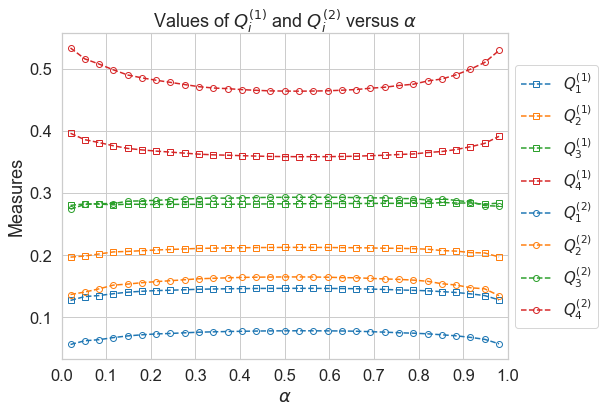

In [23]:
plot_quantile_measures(dlr_measures_1)

## Test 2:  independent exponential (p45)
$Y=x_1-x_2+x_3-x_4$, where $x_i \sim Exp(\lambda=1)$


### Objective function

In [24]:
# objective function
a_2 = [1,-1,1,-1]

def objfun2(x):
    result = a_2[0] * x[:, 0] + a_2[1] * x[:, 1] + a_2[2] * x[:, 2] + a_2[3] * x[:, 3]
    return result

### Parameters

In [25]:
# dimension of inputs
n_params_2 = np.size(a_2) # 4

### pdf of output

In [26]:
N=2**13
skip = 0

# Generate uniform distributed sample
X02 = cp.generate_samples(order=N+skip, domain=n_params_2 , rule="S").T
X02 = X02[skip:, :n_params_2]
    
# Transform uniform draw into exponential draw
A_2 = expon.ppf(X02, loc=0, scale=1)

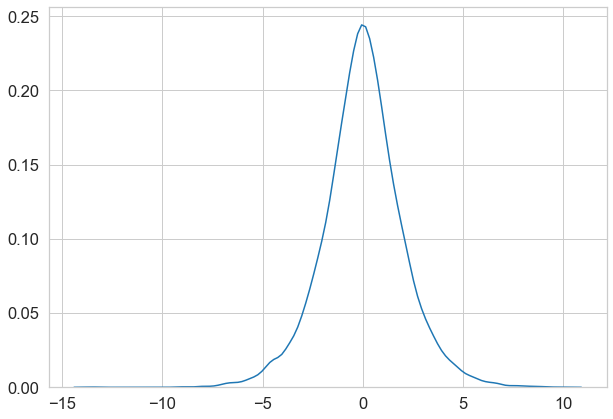

In [27]:
# The PDF of output Y(a)
Y2 = objfun2(A_2)

# fig. 3.(b)
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.kdeplot(Y2)

### The Brute Force estimator

In [29]:
# N=3000
bf_measures_2 = mc_quantile_measures("brute force", objfun2, n_params_2, 0, 1, "Exponential",3000,)

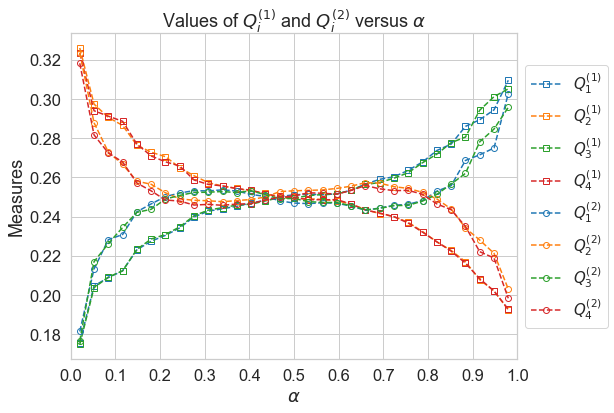

In [30]:
plot_quantile_measures(bf_measures_2)

### The DLR estimator

In [33]:
dlr_measures_2 = mc_quantile_measures("DLR", objfun2, n_params_2, 0, 1, "Exponential",2 ** 13,)

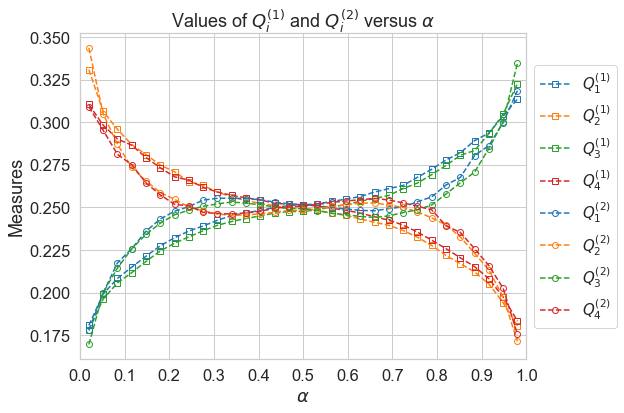

In [34]:
plot_quantile_measures(dlr_measures_2)

## Test 3:  independent uniform (p45)
$Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$, where $x_i$ uniform distributed on the interval$[-\pi,\pi]$

### Objective function

In [35]:
def ishigami(x, a=7, b=0.1):
    rslt = (1 + b * x[2] ** 4) * np.sin(x[0]) + a * np.sin(x[1]) ** 2
    return rslt

def ishigami_transposed(x, a=7, b=0.1):
    """Simple linear function model but with variables stored in columns."""
    return ishigami(x.T, a=7, b=0.1)

### Parameters

In [36]:
# dimension of inputs
n_params_3 = 3 

# lower bound of uniform distribution
lower_bound = -np.pi
# interval of uniform distribution
interval = 2 * np.pi

### pdf of output

In [37]:
N=2**13
skip = 0

# Generate uniform distributed sample
A_3 = np.zeros((N,n_params_3)) 
skip = 0
X03 = cp.generate_samples(order=N+skip, domain=n_params_3, rule="S").T
X03 = X03[skip:, :n_params_3]
    
A_3 = uniform.ppf(X03,lower_bound,interval)

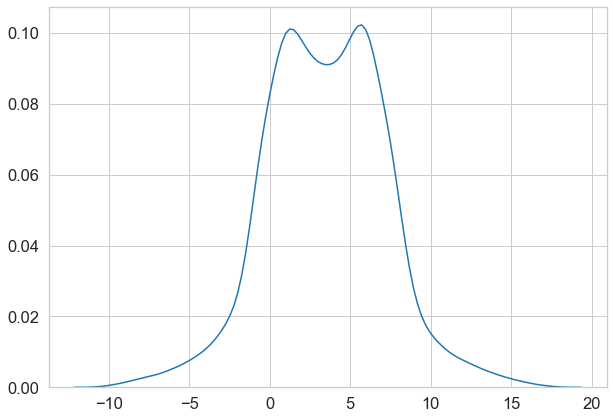

In [38]:
# The PDF of output Y(a)
Y3 = ishigami_transposed(A_3)

# fig. 3.(b)
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.kdeplot(Y3)

### The Brute Force estimator

In [40]:
# N=3000
bf_measures_3 = mc_quantile_measures("brute force", ishigami_transposed, n_params_3, lower_bound, interval, "Uniform",3000,)

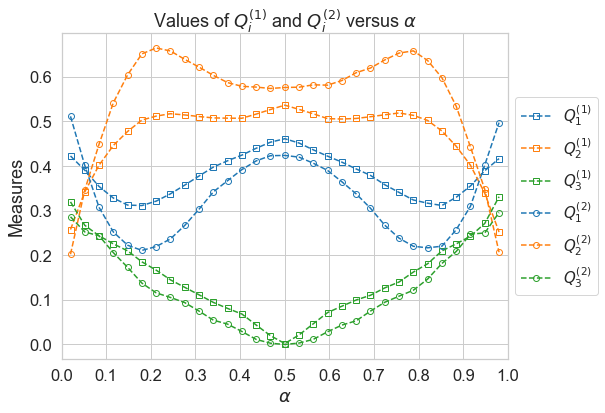

In [41]:
plot_quantile_measures(bf_measures_3)

### DLR estimator

In [46]:
dlr_measures_3 = mc_quantile_measures("DLR", ishigami_transposed, n_params_3, lower_bound, interval, "Uniform", n_draws=2 ** 13, skip=0,)

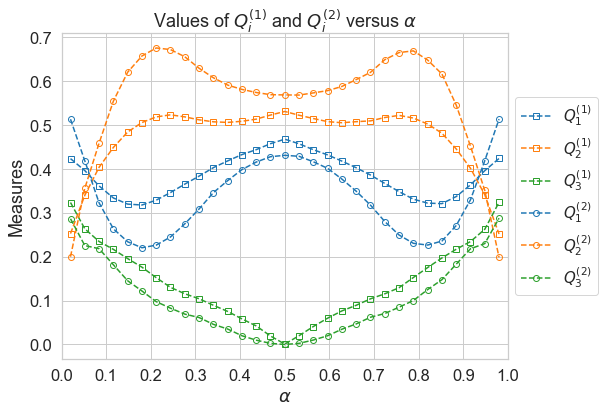

In [47]:
plot_quantile_measures(dlr_measures_3)

## Test 4: correlated multivariate normal
$Y=x_1 x_3+x_2 x_4$, where$(x_1,x_2,x_3,x_4) \sim N(\mu, \Sigma_x)$ 

### Objective function

In [44]:
def objfun4(x):
    result = x[:, 0] * x[:, 2] + x[:, 1] * x[:, 3]
    return result

### Parameters

In [45]:
mean_4 = np.array([0, 0, 250, 400])

cov_4 = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)

# dimension of inputs
n_params_4 = np.size(mean_4)

### pdf of output

In [187]:
# Generate uniform distributed sample
A_4 = np.zeros((N,n_params_4)) 
skip = 0
X04 = cp.generate_samples(order=N+skip, domain=n_params_4, rule="S").T
X04 = X04[skip:, :n_params_4]
 
# transform sample from uniform to multivariate normal
X4 = norm.ppf(X04)
cholesky = np.linalg.cholesky(cov_4)
A_4 = n_params_4 + cholesky.dot(X4.T).T

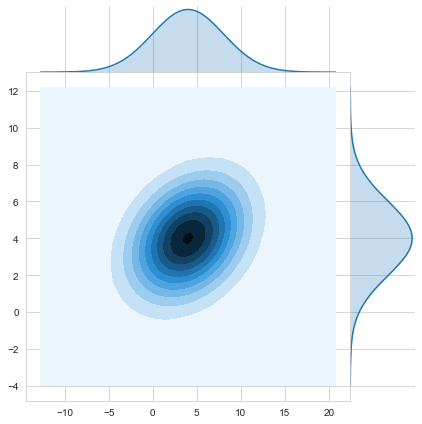

In [188]:
# check the distribution of sample
sns.jointplot(x=A_4[:,0],
              y=A_4[:,1], 
              kind="kde", 
              space=0);

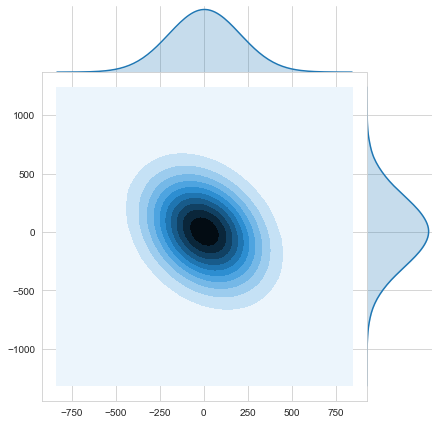

In [189]:
# check the distribution of sample
sns.jointplot(x=A_4[:,2],
              y=A_4[:,3], 
              kind="kde", 
              space=0);

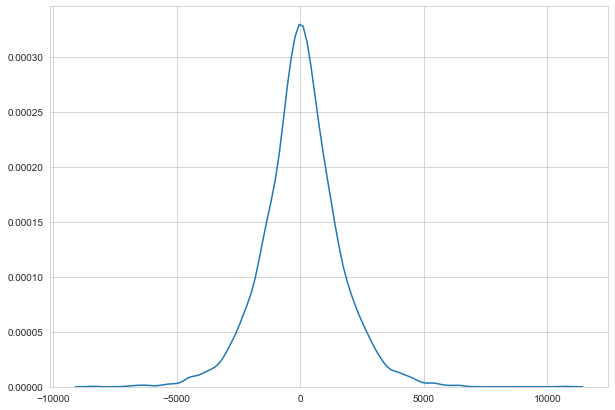

In [190]:
# The PDF of output Y(a)
Y4 = objfun4(A_4)

# fig. 3.(b)
plt.figure(figsize=(10,7))
sns.kdeplot(Y4)

### The Brute Force estimator

In [49]:
# N=3000
bf_measures_4 = mc_quantile_measures("brute force", objfun4, n_params_4, mean_4, cov_4, "Normal",3000,)

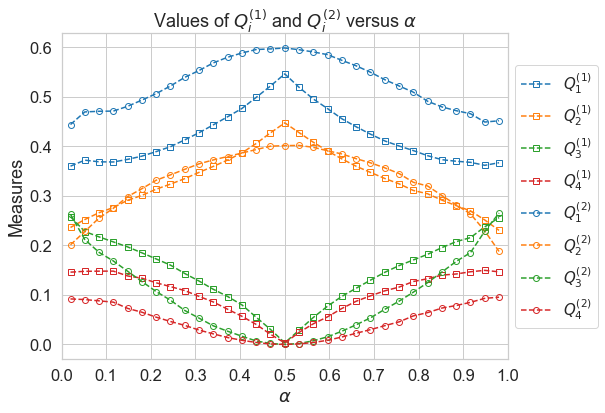

In [50]:
plot_quantile_measures(bf_measures_4)

### The DLR estimator

In [51]:
dlr_measures_4 = mc_quantile_measures("DLR", objfun4, n_params_4, mean_4, cov_4, "Normal", n_draws=2 ** 13,)

In [ ]:
plot_quantile_measures(dlr_measures_4)

In [193]:
# sobol indice given in the paper
sobol_4 = np.array([0.507, 0.399, 0, 0])

# for plot convinence
sobol_4 = np.tile(sobol_4, (len(alp), 1))